<a href="https://colab.research.google.com/github/AINetServices/training-projects/blob/main/chart_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install langgraph
%pip install langchain_groq
%pip install langchain_community
%pip install python-dotenv
%pip install TavilySearchResults
%pip install langchain_experimental


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\chris\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\chris\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\chris\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\chris\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement TavilySearchResults (from versions: none)
ERROR: No matching distribution found for TavilySearchResults
You should consider upgrading via the 'c:\Users\chris\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\chris\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


C:\Users\chris\AppData\Local\Temp\ipykernel_29220\2745716414.py:26: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3, tavily_api_key=TAVILY_API_KEY)


Creating line chart for: How is education i n australia cmpared to other countries display in line chart
Starting research and chart generation...

--- Step 1 (Researcher) ---
Content: ...

--- Step 2 (call_tool) ---
Content: [{"title": "Australia - Overview of the education system (EAG 2025)", "url": "https://gpseducation.oecd.org/CountryProfile?primaryCountry=AUS&treshold=10&topic=EO", "content": "Compared to other count...

--- Step 3 (Researcher) ---
Content: DATA_READY: The data shows that Australia has a relatively high employment rate of 25-34 year-old women with general upper secondary or post-secondary non-tertiary education (72.9%, rank 9/35) and a r...

--- Step 4 (ChartGenerator) ---
Content:  

...
CHART_CREATED

--- Step 5 (call_tool) ---
Content: Chart created and saved as chart.png...

--- Process Complete ---

Displaying the generated chart:


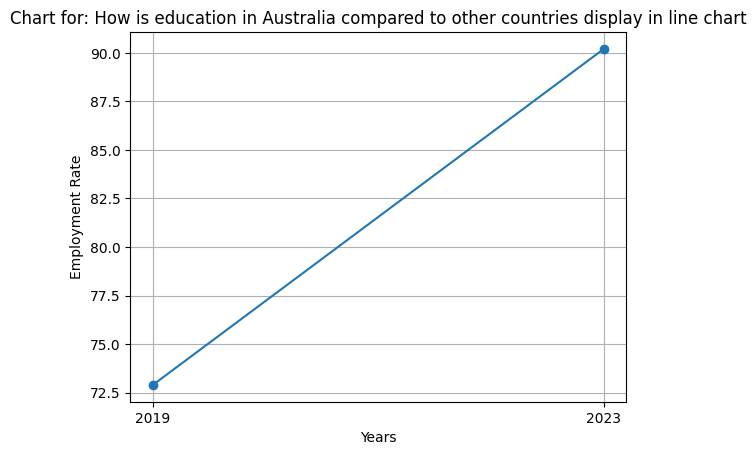

In [1]:
import os
import re
from dotenv import load_dotenv
load_dotenv()

import functools
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated, Sequence, TypedDict, Literal
import operator

# Load API keys
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Initialize LLM
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0, api_key=GROQ_API_KEY)

# --- Tools ---
search_tool = TavilySearchResults(max_results=3, tavily_api_key=TAVILY_API_KEY)

@tool
def python_repl(code: str):
    """Runs python code and returns the output. Can create charts and visualizations."""
    try:
        # Create a safe execution environment
        exec_globals = {}
        exec(code, exec_globals)
        
        # Check if matplotlib was used and save the plot
        if 'plt' in exec_globals:
            plt = exec_globals['plt']
            if plt.get_fignums():
                plt.savefig("chart.png", dpi=100, bbox_inches='tight')
                plt.close()
                return "Chart created and saved as chart.png"
        
        return "Code executed successfully"
    except Exception as e:
        return f"Error: {e}"

# --- Helper to create agent ---
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant. Use provided tools when needed. Available tools: {tool_names}. {system_message}"),
        MessagesPlaceholder(variable_name="messages"),
    ])
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([t.name for t in tools]))
    return prompt | llm.bind_tools(tools)

# --- State Definition ---
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_query: str
    chart_type: str

# --- Agent Node Wrapper ---
def agent_node(state, agent, name):
    try:
        result = agent.invoke(state)
        if not isinstance(result, ToolMessage):
            result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
        return {"messages": [result], "sender": name}
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error in {name}: {e}", name=name)], "sender": name}

# --- Chart Type Detection ---
def extract_chart_type(query):
    """Extract appropriate chart type from user query"""
    query_lower = query.lower()
    
    chart_mappings = {
        "bar chart": ["bar", "compar", "categor", "rank"],
        "line chart": ["line", "trend", "over time", "progress", "growth"],
        "pie chart": ["pie", "percentage", "proportion", "share", "distribution"],
        "scatter plot": ["scatter", "correlation", "relationship", "x y"],
        "histogram": ["histogram", "distribution", "frequency", "density"]
    }
    
    # Check for explicit chart type mentions
    for chart_type, keywords in chart_mappings.items():
        if chart_type in query_lower:
            return chart_type
        for keyword in keywords:
            if keyword in query_lower:
                return chart_type
    
    # Default based on query content
    if any(word in query_lower for word in ["time", "year", "month", "trend"]):
        return "line chart"
    elif any(word in query_lower for word in ["compare", "different", "various"]):
        return "bar chart"
    elif any(word in query_lower for word in ["percentage", "share", "part"]):
        return "pie chart"
    else:
        return "bar chart"  # Most versatile default

# --- Data Extraction from Research ---
def extract_structured_data(content):
    """Extract any numerical data from research content"""
    data_points = []
    
    # Pattern for percentages: 3.5%, 25%, etc.
    percentage_pattern = r'(\d+\.?\d*)%'
    percentages = re.findall(percentage_pattern, content)
    if percentages:
        data_points.extend([f"{p}%" for p in percentages])
    
    # Pattern for numbers with context: "2022: 3.6 million", "temperature: 25°C"
    number_context_pattern = r'(\d{4}):\s*([\d\.,]+)|(\w+):\s*([\d\.,]+)'
    context_matches = re.findall(number_context_pattern, content)
    
    # Pattern for standalone numbers that might be data points
    number_pattern = r'\b(\d{2,4}|\d+\.\d+)\b'
    numbers = re.findall(number_pattern, content)
    
    # Extract years mentioned
    year_pattern = r'\b(20\d{2}|19\d{2})\b'
    years = re.findall(year_pattern, content)
    
    return {
        "percentages": percentages,
        "context_data": context_matches,
        "numbers": numbers,
        "years": years,
        "raw_content": content[:500]  # First 500 chars for context
    }

# --- Agent Creators ---
def create_research_agent(user_query, chart_type):
    system_message = f"""Research the topic: '{user_query}'
    
    Your goal is to find numerical data, statistics, and measurable information that can be visualized in a {chart_type}.
    
    Look for:
    - Numbers, percentages, statistics
    - Yearly data, trends over time
    - Comparative data between different categories
    - Any quantitative information
    
    Once you have gathered relevant data, summarize it clearly and say 'DATA_READY: [summary of found data]'
    
    If you cannot find specific numerical data, describe what information would be needed to create a {chart_type}."""
    
    return create_agent(llm, [search_tool], system_message=system_message)

def create_chart_agent(user_query, chart_type, research_data):
    structured_data = extract_structured_data(research_data)
    
    system_message = f"""Create Python code to generate a {chart_type} based on the research data.

    Research topic: '{user_query}'
    Chart type: {chart_type}
    
    Data found: {structured_data}
    
    IMPORTANT: Generate complete, runnable Python code that:
    1. Imports necessary libraries (matplotlib.pyplot as plt)
    2. Creates sample data based on the research context
    3. Generates a {chart_type} with proper labels and title
    4. Saves the chart as 'chart.png'
    5. Returns confirmation when done
    
    Since actual data may not be complete, create reasonable sample data that represents the research topic.
    
    Example structure:
    import matplotlib.pyplot as plt
    # Create data based on research context
    # Generate the chart
    plt.title('Chart for: {user_query}')
    plt.savefig('chart.png')
    print('CHART_CREATED')
    
    Make the chart informative and well-labeled."""
    
    return create_agent(llm, [python_repl], system_message=system_message)

# --- Tool Node ---
tool_node = ToolNode([search_tool, python_repl])

# --- Router Function ---
def router(state) -> Literal["call_tool", "__end__", "ChartGenerator", "Researcher"]:
    messages = state.get("messages", [])
    if not messages:
        return "Researcher"

    last_message = messages[-1]
    content = getattr(last_message, 'content', '')
    sender = state.get("sender", "")

    if isinstance(last_message, ToolMessage):
        return sender


    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "call_tool"

    # Completion conditions
    if "DATA_READY:" in content or "DATA_FOUND:" in content:
        return "ChartGenerator"
    elif "CHART_CREATED" in content or "chart.png" in content:
        return "__end__"
    elif "Error:" in content:
        return "__end__"

    # Default routing
    if sender == "Researcher":
        return "ChartGenerator"
    else:
        return "Researcher"

# --- Graph Construction ---
workflow = StateGraph(AgentState)

def research_node(state):
    agent = create_research_agent(
        state.get("user_query", ""), 
        state.get("chart_type", "bar chart")
    )
    return agent_node(state, agent, "Researcher")

def chart_node(state):
    # Extract research data from previous messages
    research_data = ""
    for msg in state.get("messages", []):
        content = getattr(msg, 'content', '')
        if "DATA_READY:" in content or "DATA_FOUND:" in content:
            research_data = content
            break
    
    agent = create_chart_agent(
        state.get("user_query", ""),
        state.get("chart_type", "bar chart"),
        research_data
    )
    return agent_node(state, agent, "ChartGenerator")

# Add nodes
workflow.add_node("Researcher", research_node)
workflow.add_node("ChartGenerator", chart_node)
workflow.add_node("call_tool", tool_node)

# Add edges
workflow.add_conditional_edges(
    "Researcher",
    router,
    {
        "call_tool": "call_tool",      # Tool execution
        "ChartGenerator": "ChartGenerator",  # Data ready
        "__end__": END                 # Error or completion
    }
)

workflow.add_conditional_edges(
    "ChartGenerator", 
    router,
    {
        "call_tool": "call_tool",      # Code execution
        "Researcher": "Researcher",    # Need more research
        "__end__": END                 # Chart created or error
    }
)

workflow.add_conditional_edges(
    "call_tool",
    lambda state: state["sender"],  # Return to calling agent
    {
        "Researcher": "Researcher",
        "ChartGenerator": "ChartGenerator"
    }
)

workflow.add_edge(START, "Researcher")
graph = workflow.compile()

# --- Main Function ---
def create_chart_for_question(question):
    """Create a chart based on any research question"""
    chart_type = extract_chart_type(question)
    
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "sender": "User",
        "user_query": question,
        "chart_type": chart_type
    }

    print(f"Creating {chart_type} for: {question}")
    print("Starting research and chart generation...")

    # Execute the graph
    for step, output in enumerate(graph.stream(initial_state, {"recursion_limit": 20})):
        node_name = list(output.keys())[0]
        message = output[node_name]["messages"][-1]
        print(f"\n--- Step {step + 1} ({node_name}) ---")
        print(f"Content: {message.content[:200]}...")  # First 200 chars

        # Break on completion
        if any(phrase in getattr(message, 'content', '') for phrase in ["CHART_CREATED", "chart.png", "Error:"]):
            break

    print("\n--- Process Complete ---")

    # Display chart if created
    if os.path.exists("chart.png"):
        try:
            from IPython.display import Image, display
            print("\nDisplaying the generated chart:")
            display(Image(filename="chart.png"))
        except:
            print("Chart saved as 'chart.png'")
    else:
        print("No chart was created. Check the process output above.")

# --- Example Usage ---
if __name__ == "__main__":
    # Test with various types of questions
    test_questions = [
        "How has Australia's population grown over the last 10 years?",
        "Compare renewable energy usage between different European countries",
        "What percentage of people use different social media platforms?",
        "Relationship between exercise frequency and health outcomes",
        "Distribution of income levels in major US cities"
    ]
    
    # Use the first question or replace with your own
    question = "How is education i n australia cmpared to other countries display in line chart"
    create_chart_for_question(question)